<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/voxceleb_data_handle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

#import libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math

In [2]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"


--2021-09-27 19:46:23--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  34.6MB/s    in 4m 6s   

2021-09-27 19:50:29 (34.6 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

In [4]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

In [5]:
#number of videos available
print('Number of videos available: ', len(vid_paths))

Number of videos available:  36237


In [6]:
#functions

#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

In [8]:
#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
0,id00012,n000012,m,dev
1,id00015,n000015,m,dev
2,id00016,n000016,m,dev
3,id00017,n000017,m,test
4,id00018,n000018,m,dev


In [9]:
#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)

In [10]:
#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


In [14]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

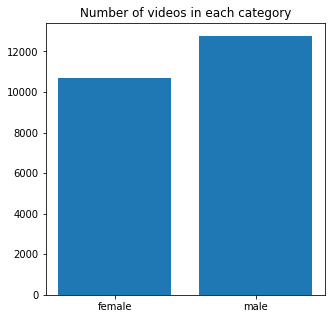

In [15]:
#see how many males and females we have
gender = ['female', 'male']
count = [len(np.where(np.array(labels) == 0)[0]), len(np.where(np.array(labels) == 1)[0])]

plt.figure(figsize = (5, 5))
plt.bar(gender, count)
plt.title('Number of videos in each category')
plt.show()

In [112]:
#pic a random video and play it

rand_idx = np.random.choice(np.arange(0, len(video_files)))
file_path = video_files[rand_idx]
file_label = labels[rand_idx]
print(file_path)
print('\nMale\n' if file_label == 1 else '\nFemale\n')

mp4 = open(file_path, 'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/content/mp4/id04366/xiS-GeTD-Fg/00253.mp4

Male



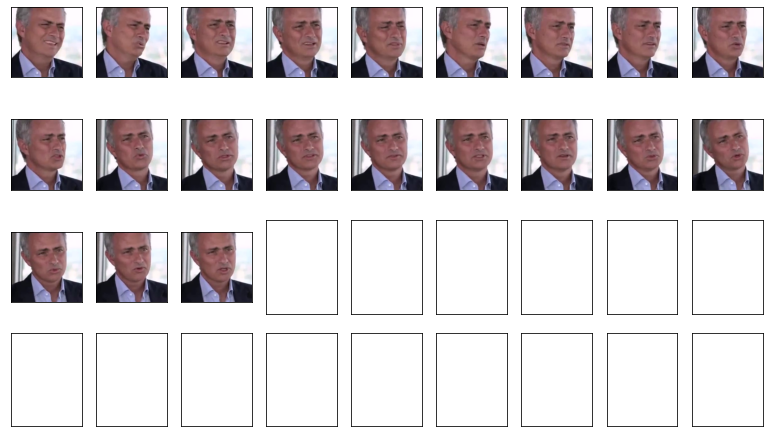

In [113]:
#select the random video above and plot the frames of the video
count = 0
cap = cv2.VideoCapture(video_files[rand_idx])

ncols = 10
nrows = 5

# create the plots
fig = plt.figure(figsize = (15, 10))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(1, nrows) for c in range(1, ncols) ]

# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#index for the axis
a = 0

x = 0
while(cap.isOpened()):
    #frameId = cap.get(1) #current frame number
    ret, frame = cap.read()

    if x % 10 == 0 and (frame is not None):

      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      axes[a].imshow(frame.astype('uint8'))
      a += 1     
    
    if (ret != True):
        break
    x += 1
cap.release()
